# US EPA Air Quality History
This notebook illustrates how to request data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The end goal of this notebook is to get to some values that we might use for the Air Quality Index or AQI. The AQI index is meant to represent how healthy or clean the air is on any day.

## License
This notebook uses partial code from example that was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023



## Preliminaries and Constants

In [77]:
# 
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests.
#
import requests

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



##  Making a sign-up request


In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [4]:
print("Requesting SIGNUP ...")
response = request_signup("aprilgg@uw.edu")
print(json.dumps(response,indent=4))


Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-09T14:30:24-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=aprilgg@uw.edu"
        }
    ],
    "Data": [
        "You should receive an email containing your new key shortly."
    ]
}


In [17]:
#API token
USERNAME = ""
APIKEY = ""


## Making a list request
Getting information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. 

In [18]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [19]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.


In [20]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [21]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [22]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

Following analysis based on Lawton, Oklahoma

In [23]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'Lawton' :        {'city'   : 'Lawton',
                       'county' : 'Comanche',
                       'state'  :'Oklahoma',
                       'fips'   : '40031',
                       'latlon' : [34.6036, -98.3959] }
    
}


Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. 

In [24]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Lawton']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['Lawton']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0640",
        "value_represented": null
    },
    {
        "code": "0641",
        "value_represented": null
    },
    {
        "code": "0643",
        "value_represented": null
    },
    {
        "code": "0644",
        "value_represented": null
    },
    {
        "code": "0645",
        "value_represented": null
    },
    {
        "code": "0646",
        "value_represented": null
    },
    {
        "code": "0647",
        "value_represented": "USPHS LAWTON INDIAN HOSPITAL"
    },
    {
        "code": "0648",
        "value_represented": "WEATHER STATION - MEDICINE PARK MESONET SITE"
    },
    {
        "code": "0649",
        "value_represented": "LAWTON SOUTH"
    },
    {
        "code": "0650",
        "value_represented": null
    },
    {
        "code": "0651",
        "value_represented": "LAWTON NORTH"
    },
    {
        "code": "9000",
        "value_represented": null
    }
]



The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


## Making a daily summary request from monitoring station

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

In [25]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



Following functions are requesting daily AQI for the fire season(May 1st to Oct. 31st) for each year, due to begin_date and end_date has to be same year. 

In [71]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['Lawton']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Lawton']['fips'][2:]

def yearly_gas_req(year,request_data):
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031")
    print(f"Response for the gaseous pollutants for {year}...")

    if gaseous_aqi["Header"][0]['status'] == "Success":
        return gaseous_aqi['Data']
    elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
        print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
    else:
        print(json.dumps(gaseous_aqi,indent=4))
        
def yearly_part_req(year, request_data):
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031")
    print(f"Response for the particulate pollutants for {year}...")

    if particulate_aqi["Header"][0]['status'] == "Success":
        return particulate_aqi['Data']
    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
    else:
        print(json.dumps(particulate_aqi,indent=4))


Following function is requesting AQI for the past 50 years(1963-2023).

In [35]:
# Requesting gas aqi for past 50 years
gas_aqi_list = []

for year in range(1963, 2024):
    gas_aqi_year = yearly_gas_req(year, request_data)
    if gas_aqi_year is None:
        continue
    
    gas_aqi_list += gas_aqi_year


Response for the gaseous pollutants for 1963...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1964...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1965...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1966...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1967...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1968...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1969..

In [72]:
# Resquesing particulates aqi for past 50 years
part_aqi_list = []

for year in range(1963, 2024):
    part_aqi_year = yearly_part_req(year, request_data)
    if part_aqi_year is None:
        continue
    
    part_aqi_list += part_aqi_year

Response for the particulate pollutants for 1963...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants for 1964...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants for 1965...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants for 1966...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants for 1967...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the particulate pollutants for 1968...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the parti

Following code converts JSON responses to dataframe for readability. Then, it calculates the average yearly AQI for gaseous and particulate.

In [73]:
gas_df=pd.DataFrame(gas_aqi_list)
part_df=pd.DataFrame(part_aqi_list)

# print(gas_df.head())
print(part_df.head())

  state_code county_code site_number parameter_code  poc   latitude  \
0         40         031        0640          81102    1  34.598408   
1         40         031        0640          81102    1  34.598408   
2         40         031        0640          81102    1  34.598408   
3         40         031        0640          81102    1  34.598408   
4         40         031        0640          81102    1  34.598408   

   longitude  datum              parameter sample_duration_code  ...  \
0 -98.403942  WGS84  PM10 Total 0-10um STP                    7  ...   
1 -98.403942  WGS84  PM10 Total 0-10um STP                    7  ...   
2 -98.403942  WGS84  PM10 Total 0-10um STP                    7  ...   
3 -98.403942  WGS84  PM10 Total 0-10um STP                    7  ...   
4 -98.403942  WGS84  PM10 Total 0-10um STP                    7  ...   

  method_code                            method local_site_name  \
0         063  HI-VOL SA/GMW-1200 - GRAVIMETRIC            None   
1     

In [56]:
year_gas_df = gas_df.copy()
#converting date_local to datetime format and extract the year
year_gas_df['date_local'] = pd.to_datetime(year_gas_df['date_local'])
year_gas_df['year'] = year_gas_df['date_local'].dt.year

year_gas_df = year_gas_df.groupby(['year','parameter'])['aqi'].mean()

year_gas_df = year_gas_df.dropna().reset_index()

year_gas_df

,year,parameter,aqi
0,1981,Sulfur dioxide,0.444444
1,1983,Sulfur dioxide,2.166667
2,1984,Sulfur dioxide,0.573770
3,1986,Sulfur dioxide,2.290323
4,1987,Sulfur dioxide,8.672316
5,1988,Sulfur dioxide,11.500000
6,1989,Sulfur dioxide,19.867052
7,1990,Sulfur dioxide,12.687151
8,1991,Sulfur dioxide,1.988636
9,1992,Carbon monoxide,7.466667


In [74]:
year_part_df = part_df.copy()
#converting date_local to datetime format and extract the year
year_part_df['date_local'] = pd.to_datetime(year_part_df['date_local'])
year_part_df['year'] = year_part_df['date_local'].dt.year

year_part_df = year_part_df.groupby(['year','parameter'])['aqi'].mean()

year_part_df = year_part_df.dropna().reset_index()

year_part_df

,year,parameter,aqi
0,1988,PM10 Total 0-10um STP,29.673913
1,1989,PM10 Total 0-10um STP,29.717949
2,1990,PM10 Total 0-10um STP,29.555556
3,1991,PM10 Total 0-10um STP,25.833333
4,1992,PM10 Total 0-10um STP,28.437500
5,1993,PM10 Total 0-10um STP,27.750000
6,1994,PM10 Total 0-10um STP,26.962963
7,1995,PM10 Total 0-10um STP,25.233333
8,1996,PM10 Total 0-10um STP,21.740741
9,1997,PM10 Total 0-10um STP,25.821429


The AQI availible in each year is inconsistant. Therefore, I will create the average yearly AQI combining all AQI measurements

In [75]:
year_aqi_df = pd.concat([year_gas_df, year_part_df], ignore_index = True)
average_aqi_df = year_aqi_df.groupby(['year'])['aqi'].mean().reset_index()
average_aqi_df.head()

,year,aqi
0,1981,0.444444
1,1983,2.166667
2,1984,0.573770
3,1986,2.290323
4,1987,8.672316


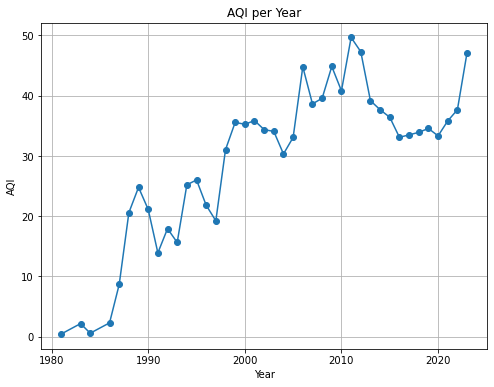

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(average_aqi_df['year'], average_aqi_df['aqi'], marker='o', linestyle='-')
plt.title('AQI per Year')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.grid(True)
plt.show()

In [81]:
average_aqi_df.to_csv('yearly_aqi.csv', index=False)